# Developing Pastas models for different wells in Bangkok, Thailand.

- A well nest at a given location may have 1-4 wells
- Simulating groundwater levels
- Calibration period: typically from 1978-2020 (based on data
availability)
- Inputs: Basin-wide Pumping
- Outputs: Pastas models (.pas files), graphs

Article Title: Hybrid data-driven, physics-based modeling of ground-
water and subsidence with application to Bangkok, Thailand

Jenny Soonthornrangsan 2023
TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.2" "basemap-data == 1.3.2" 
!pip install "basemap-data-hires == 1.3.2"
!pip install "matplotlib == 3.5.2"
!pip install mycolorpy
!pip install xlrd
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

  Using cached basemap-1.3.2.zip (155 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [10 lines of output]
  Ignoring numpy: markers 'python_version == "2.7" or (python_version >= "3.4" and python_version <= "3.9")' don't match your environment
  Ignoring numpy: markers 'python_version == "2.6" or (python_version >= "3.2" and python_version <= "3.3")' don't match your environment
  Ignoring cython: markers 'python_version == "3.2"' don't match your environment
    Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
    Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
  ERROR: Could not find a version that satisfies the requirement numpy==1.21.4 (from version

  Using cached matplotlib-3.5.2.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [600 lines of output]
  
  Edit mplsetup.cfg to change the build options; suppress output with --quiet.
  
  BUILDING MATPLOTLIB
        python: yes [3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023,
                    13:26:23) [MSC v.1916 64 bit (AMD64)]]
      platform: yes [win32]
         tests: no  [skipping due to configuration]
        macosx: no  [Mac OS-X only]
  
  C:\Users\jtsoonthornran\Anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!

[WinError 3] The system cannot find the path specified: "'/content/BKKSubPastasModels'"
C:\Users\jtsoonthornran\BKKSubPastasModels\JupyterNotebooks


fatal: destination path 'BKKSubPastasModels' already exists and is not an empty directory.
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> main



__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import os
import sys
import warnings

# Changing current directory to location of main directory
%cd "C:\Users\jtsoonthornran\BKKSubPastasModels"

# Bangkok Subsidence Model Package
import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs


C:\Users\jtsoonthornran\BKKSubPastasModels


In [3]:
# %%###########################################################################
# Plotting settings
###############################################################################

plt.rc("font", size=10)  # controls default text size
plt.rc("axes", titlesize=10)  # fontsize of the title
plt.rc("axes", labelsize=7)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=7)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=7)  # fontsize of the y tick labels
plt.rc("legend", fontsize=6)  # fontsize of the legend

Currently, producing graphs for one well nest: LCBKK013 or BKK013 in the paper.

- Figure 8 in _Groundwater_ paper

Change `list_wellnest_flag = 1` to run for all well nests (supplemental information 1.4 graphs)

Figures for each well nest

*   Simulated vs. observed groundwater head for each well that was available
*   Basin-wide pumping rates which were used as the only input time series



In [4]:
# %%###########################################################################
# Pastas settings
###############################################################################

# If saving model, save_model = 1
save_model = 0

# If importing previous saved models, import_model = 1
import_model = 1

# If saving graphs, save_graph = 1
save_graph = 0

# Publication graphs
paper_graph = 1

# Additional figures
add_graph = 0

# Folder to save/import graph and model
modelpath = os.path.abspath("models")
figpath = os.path.abspath("figures")
pumppath = os.path.join(os.path.abspath("inputs"), 'BasinPumping.xlsx')
pumpsheet = 'EstTotalPump_54-60_Int50'

# If running with pumping
# If basin wide pumping set pump_basin_flag to 1
pump_basin_flag = 1

# Pumping response function
pump_rfunc = ps.Gamma()

# Solver
# Options: ps.LmfitSolve, ps.LeastSquares
# solver = ps.LeastSquares()

# Noise model
noise_TF = True

# Option to run all well nests, set flag to 1
list_wellnest_flag = 0

# If running only one well nest, set flag to 0, WellNest Name
Wellnest_name = ["LCBKK013"]

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

# All well nest list
if list_wellnest_flag == 1:

    files = os.listdir(tot_path)
    files = [i.replace('.xlsx', '') for i in files
             if i.startswith('LC') and "_" not in i]

else:
    files = Wellnest_name

INFO: Time Series 'Head': 4 nan-value(s) was/were found and filled with: drop.



GW obs imported for LCBKK013 and PD32


Model initialized for GW


Pumping obs added basin-wide

Running....


INFO: C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_PD32_GW_1978_2005_model.pas file successfully exported
INFO: Time Series 'Head': 7 nan-value(s) was/were found and filled with: drop.



GW obs imported for LCBKK013 and NL45


Model initialized for GW


Pumping obs added basin-wide

Running....


INFO: C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_NL45_GW_1978_2005_model.pas file successfully exported
INFO: Time Series 'Head': 5 nan-value(s) was/were found and filled with: drop.



GW obs imported for LCBKK013 and NB38


Model initialized for GW


Pumping obs added basin-wide

Running....


INFO: C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_NB38_GW_1978_2005_model.pas file successfully exported
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:1640: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0)  # Before making the table
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.p

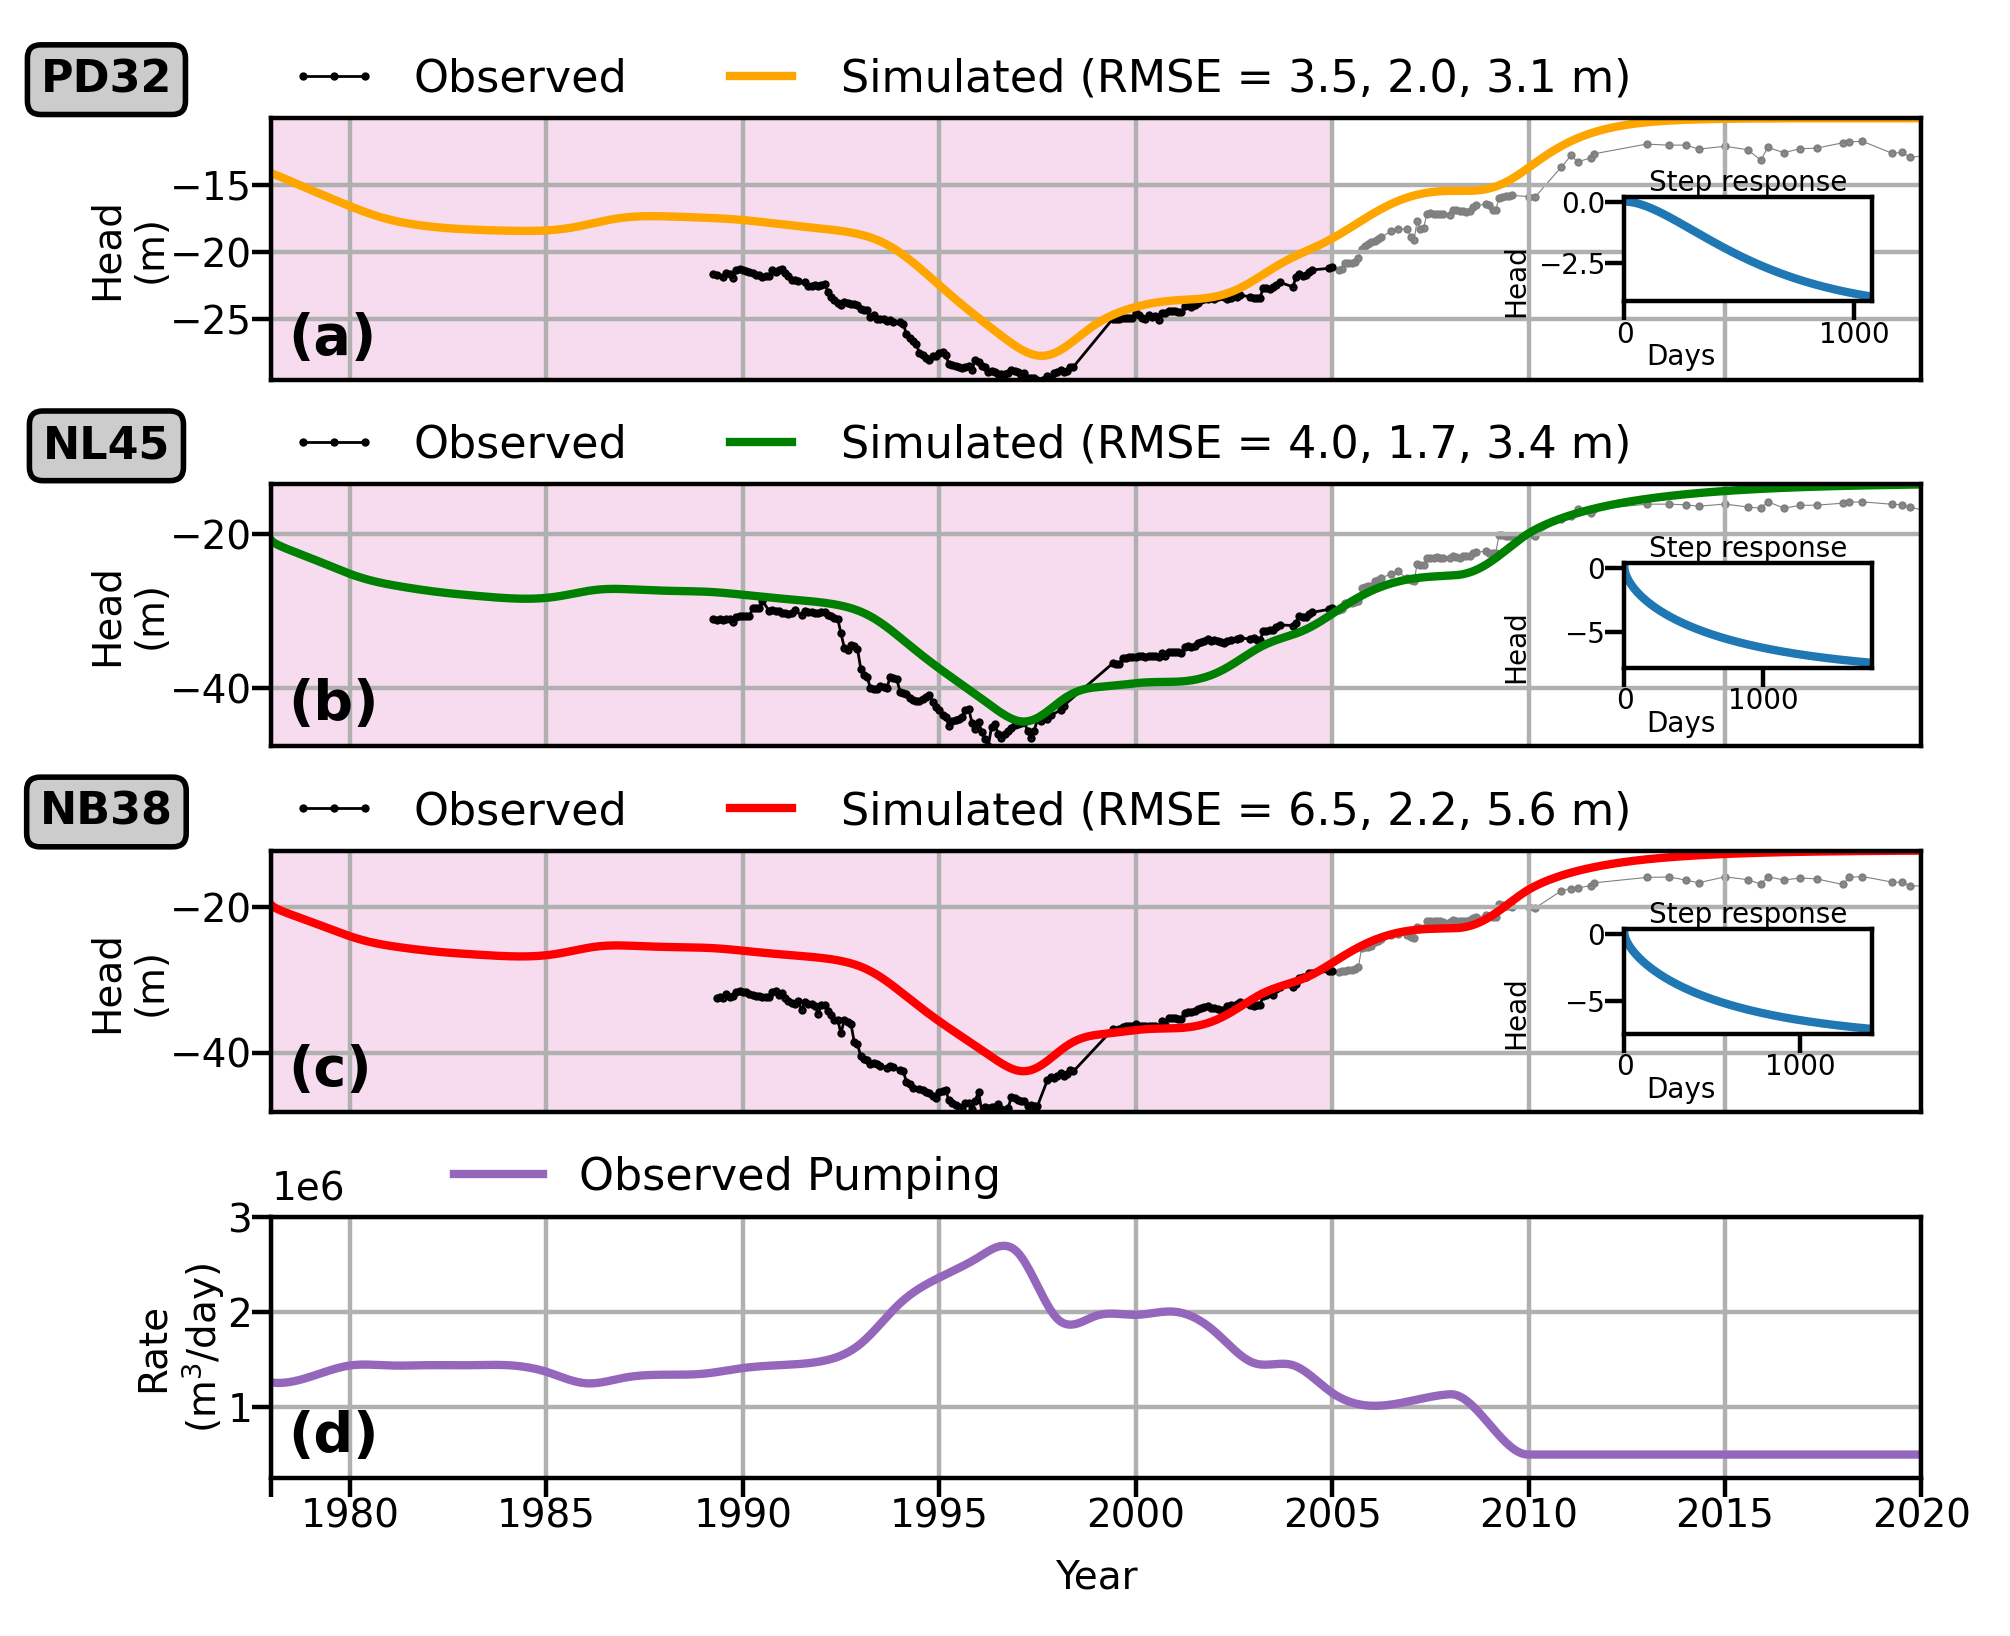

In [5]:
# %%###########################################################################
# Pastas settings
###############################################################################

# If saving model, save_model = 1
save_model = 1

# If importing previous saved models, import_model = 1
import_model = 0

# If saving graphs, save_graph = 1
save_graph = 1

# Publication graphs
paper_graph = 1

# Additional figures
add_graph = 0

# Folder to save/import graph and model
modelpath = os.path.abspath("models")
figpath = os.path.abspath("figures")
pumppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
pumpsheet = "EstTotalPump_54-60_Int50"

# If running with pumping
# If basin wide pumping set pump_basin_flag to 1
pump_basin_flag = 1

# Pumping response function
pump_rfunc = ps.Gamma()

# Calibration period
calitime_min = "1978"
calitime_max = "2005"

# Solver
# Options: ps.LmfitSolve, ps.LeastSquares
# solver = ps.LeastSquares()

# Noise model
noise_TF = True

# Option to run all well nests, set flag to 1
list_wellnest_flag = 0

# If running only one well nest, set flag to 0, WellNest Name
Wellnest_name = ["LCBKK013"]

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

# All well nest list
if list_wellnest_flag == 1:

    files = os.listdir(tot_path)
    files = [i.replace(".xlsx", "") for i in files
             if i.startswith("LC") and "_" not in i]

else:
    files = Wellnest_name

###############################################################################
# Creating/Importing and Plotting Pastas Model
###############################################################################

# For each well nest
for Wellnest_name in files:

    # Only open figures for each well nest
    plt.close("all")

    # Saving results for each well nest
    models = []
    time_mins = []
    time_maxs = []
    well_names = []

    # Reading in groundwater data
    full_path = os.path.join(tot_path, Wellnest_name + ".xlsx")
    data = pd.read_excel(full_path, skiprows=3)

    # For all wells in well nest
    for wells in data.columns[-(len(data.columns)-2):]:

        # Name of well as a string
        well_name = wells

        #######################################################################
        # Creating Pastas Model
        #######################################################################
        # If not importing, then creating new models
        if import_model == 0:

            # Preprocessing head data
            # Inputing in raw data for well nest and well name
            # Output: head data relative to 0 for the entire well nest
            #         head data relative to 0 m for specific well
            all_head_data, gw_well_head = mfs.GW_Data_Process(data,
                                                              well_name)
            print("\nGW obs imported for " + Wellnest_name + " and " +
                  well_name + "\n")

            # CORRECTING GW HEAD DATA TO LAND SURFACE (COASTAL DEM 2.1)
            # Reading in land surface elevation for each well nest
            landsurf_path = os.path.join(tot_path,
                                         "LandSurfElev_GWWellLocs.xlsx")
            landsurf_data = pd.read_excel(landsurf_path,
                                          sheet_name="2.1",
                                          usecols="C:F",
                                          index_col=0)

            # Correcting head relative to 0 m to be head relative to a
            # global datum.
            # Corrected by adding land surface elevation values to
            # head values relative to 0 m
            gw_well_head.Head += (landsurf_data.RASTERVALU.loc[Wellnest_name])

            # Saving years and annual average heads
            gw_well_head["year"] = gw_well_head.index.year  # Saving year
            gw_year = gw_well_head.groupby(gw_well_head["year"]).mean()
            gw_year["Date"] = pd.to_datetime(gw_year.index, format="%Y")
            gw_year.index = gw_year.Date  # Setting index as date
            gw_year["year"] = gw_year.index.year  # Saving year

            # Setting time min and time max to first and last obs year
            time_min = str(gw_year[gw_year.Head.notna()].year[0])
            time_max = str(gw_year[gw_year.Head.notna()].year[-1])

            # Gets rid of data not within min and max time
            gw_year = gw_year[(gw_year["year"] >= int(time_min)) &
                              (gw_year["year"] <= int(time_max))]

            # If GW well does not have data within time period, skips this well
            if gw_year.Head.isnull().all():
                print("\nSkipping ", well_name,
                      "because no head values in time period\n\n\n")
                continue

            # Initializing model
            model = ps.Model(gw_well_head.Head)
            print("\nModel initialized for GW\n")

            # Initial steady state heads estimate for d constant
            # Steady state heads already realtive to same global datum
            # as land surface elevation
            SS_path = os.path.join(tot_path,
                                   "SS_Head_GWWellLocs.xlsx")
            SS_data = pd.read_excel(SS_path,
                                    sheet_name="SS_Py",
                                    index_col=0)

            # Getting steady state heads according to aquifer
            if "BK" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "BK"]

            elif "PD" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "PD"]

            elif "NL" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "NL"]

            elif "NB" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "NB"]

            # Setting d parameter to SS heads and to vary +/- initial
            # estimates
            model.set_parameter(name="constant_d",
                                initial=initial_d,
                                pmin=initial_d-10,
                                pmax=initial_d+10,
                                vary=True)

            ###################################################################
            # Adding pumping data
            ###################################################################
            if pump_basin_flag == 1:

                # Daily interpolated and estimated pumping rates for the basin
                # from simulated (Chula report)
                EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet,
                                           index_col=0, parse_dates=["Date"])

                # Creating stress model
                EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc,
                                             name="well", settings="well",
                                             up=False)
                # Adding stress model
                model.add_stressmodel(EstTotPump_)
                print("\nPumping obs added basin-wide\n")

            ###################################################################
            # Solving/Saving Pastas Model
            ###################################################################
            # Try running model
            try:
                print("Running....")

                # If noise model True
                if noise_TF:

                    # First run is not with noise model
                    # Gets first parameter estimates
                    # Warm up is 30 years
                    model.solve(tmin=calitime_min, tmax=calitime_max,
                                report=False, noise=False,
                                solver=ps.LeastSquares(), warmup=365*30)

                    # Second run with noise model using initial
                    # parameters as the calibrated parameters from
                    # first run
                    model.solve(tmin=calitime_min, tmax=calitime_max,
                                initial=False, report=False,
                                noise=noise_TF, solver=ps.LeastSquares(),
                                warmup=365*30)

                # Noise model False
                else:

                    # First run is not with noise model
                    # Gets first parameter estimates
                    # Warm up is 30 years
                    model.solve(tmin=calitime_min, tmax=calitime_max,
                                report=False, noise=False,
                                solver=ps.LeastSquares(), warmup=365*30)

                    # Second run with noise model using initial
                    # parameters as the calibrated parameters from
                    # first run
                    model.solve(tmin=calitime_min, tmax=calitime_max,
                                initial=False, report=False,
                                noise=noise_TF, solver=ps.LeastSquares(),
                                warmup=365*30)

            # If time series out of bounds
            except ValueError:
                print("Time series out of bounds.\nCannot run model")
                sys.exit()

            # If saving model
            if save_model == 1:
                model.to_file(modelpath + "/" + Wellnest_name + "_" +
                              well_name + "_GW_" + calitime_min + "_" + calitime_max +
                              "_model.pas")

        #######################################################################
        # Importing Pastas Model
        #######################################################################
        # If importing Pastas model
        else:

            # Model files
            modelfiles = os.listdir(modelpath)

            # If file exists:
            try:

                # Load existing model
                wellmodel = [s for s in modelfiles
                             if np.logical_and(Wellnest_name in s,
                                               well_name in s)][0]
                model = ps.io.load(modelpath + "/" + wellmodel)

                # Gets time min and max from file name
                time_min = wellmodel[wellmodel.find("_1")+1:wellmodel.find("_1")+5]
                time_max = wellmodel[wellmodel.find("_2")+1:wellmodel.find("_2")+5]

                # Saving optimal parameters before deleting stress
                optiparam = model.parameters["optimal"]
                stdparam = model.parameters["stderr"]

                # Deleting stress
                model.del_stressmodel("well")

                # Adding new pumping stress time series
                # If the same pumping stress time series, then
                # optimal parameters are the same
                EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet,
                                           index_col=0, parse_dates=["Date"])
                EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc,
                                             name="well", settings="well",
                                             up=False)

                # Adding new stress model
                model.add_stressmodel(EstTotPump_)

                # Setting the same optimal parameters
                model.parameters["optimal"] = optiparam
                model.parameters["stderr"] = stdparam

            # If does not exist
            except FileNotFoundError:
                print("No model for " + Wellnest_name + "_" + well_name)
                continue

        # Saving Pastas model, Well_name
        models.append(model)
        well_names.append(well_name)

        ###########################################################################
        # Pastas Plotting and Graphing
        ###########################################################################

        # set plotting time min and time max
        if "BK" in well_name:
            ptime_min = "1986"
        else:
            ptime_min = "1978"
        ptime_max = "2020"

        # Saving time_mins and time_maxs
        time_mins.append(ptime_min)
        time_maxs.append(ptime_max)

        # If plotting additional graphs
        if add_graph == 1:

            # Plotting for calibrated time period
            ax = model.plot(tmin=ptime_min, tmax=ptime_max,
                            figsize=(10, 6))

            # Setting yaxis limits
            # Different for wells in different aquifers
            if "BK" in well_name:
                plt.ylim(-25, -5)
            elif "PD" in well_name:
                # Well nests with big variation in head
                if Wellnest_name == "LCBKK036" or \
                        Wellnest_name == "LCSPK007":
                    plt.ylim(-55, -10)
                # Rest of wells
                else:
                    plt.ylim(-30, -5)
            elif "NL" in well_name:
                plt.ylim(-70, -10)
            elif "NB" in well_name:
                plt.ylim(-60, -5)

            # If saving graphs
            if save_graph == 1:

                # First figure from plot
                # Fig name
                fig_name1 = Wellnest_name + "_" + well_name + "_GW_" + \
                    time_min + "_" + time_max + "_1.png"
                # Fig path
                full_figpath = os.path.join(figpath, fig_name1)
                # Saving fig
                plt.savefig(full_figpath, dpi=150, bbox_inches="tight",
                            format="png")

                # Second figure
                model.plots.results(tmin=ptime_min, tmax=ptime_max,
                                    figsize=(10, 6))
                # Fig name
                fig_name2 = Wellnest_name + "_" + well_name + "_GW_" + \
                    time_min + "_" + time_max + "_2.png"
                # Fig path
                full_figpath = os.path.join(figpath, fig_name2)
                # Saving fig
                plt.savefig(full_figpath, dpi=150, bbox_inches="tight",
                            format="png")

            # If not saving graphs
            else:

                model.plots.results(tmin=time_min, tmax=time_max,
                                    figsize=(10, 6))

    # If replicating publication figures
    if paper_graph == 1:

        # Calibrating
        # If calibration and validating
        califlag = [calitime_min, calitime_max]
        bkk_sub_gw.bkk_plotting.Pastas_results(models, Wellnest_name,
                                               well_names, time_mins,
                                               time_maxs, figpath, save_graph,
                                               califlag=califlag)